# Random Matrix Results

This notebook demonstrates some important results from the study of random matrices: Wigner's surmise, the semicircle law, the Tracy-Widom distribution and another distribution that I don't know the name of.

In [1]:
using RandomMatrices, Distributions, LinearAlgebra, Plots
gr()
default(leg=false)

# Wigner's Surmise

Wigner's surmise is the PDF of the difference between the two eigenvalues of a 2x2 random matrix. The simplification given here takes a matrix:

\begin{pmatrix}
x_1 & x_3\\
x_3 & x_2
\end{pmatrix}

Where the random variables, $x_i$, are drawn from normal distributions, $x_1$ and $x_2$ with variance 1 and $x_3$ with variance $^1/_2$. Wigner's Surmise in this case is given by (and derived in [this lecture](https://www.youtube.com/watch?v=Je4bU3g_QGk)):

$$\frac{1}{2}x e^{-\frac{x^2}{4}}$$

In [2]:
t = 50000  # trials
s = []

dist1 = Normal(0, 1)         # σ=1
dist2 = Normal(0, 1/sqrt(2)) # σ=1/√2
for i in 1:t
    # Sample GOE with the given variances
    x1 = rand(dist1)
    x2 = rand(dist1)
    x3 = rand(dist2)
    a = [x1 x3; x3 x2]  # symmetric matrix
    λ1,λ2 = eigvals(a) # difference between the two eigenvalues
    push!(s, abs(λ1-λ2))
end

In [3]:
wigners_surmise(x) = (1/2)x*exp(-(x^2)/4)

wigners_surmise (generic function with 1 method)

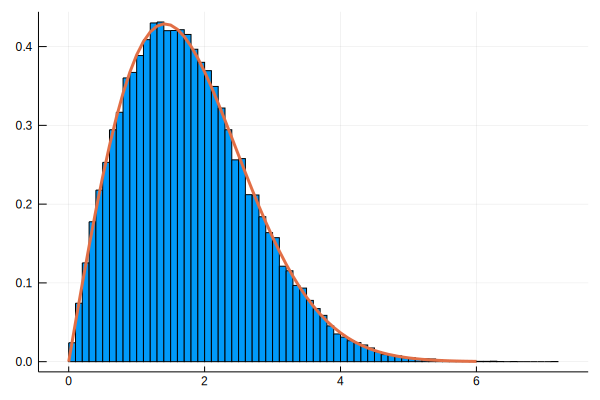

In [4]:
plot(histogram(s, normalize=:pdf))
plot!(0:0.1:6, wigners_surmise, lw=3)

# Wigner semicircle distribution

Named after the physicist Eugene Wigner and arises as the limiting distribution of eigenvalues of many random symmetric matrices as the size of the matrix approaches infinity.

The approach taken here was inspired by _Edelman, A., Sutton, B., & Wang, Y. (2014). Random matrix theory, numerical computation and applications_.

In [5]:
n = 100  # matrix size
t = 5000 # trials
v = []   # eigenvalue samples

for i in 1:t
    # Sample GOE and collect their eigenvalues
    a=randn(n,n)  # random nxn matrix of random Gaussians
    s=(a+a')/2 # symmetric matrix
    append!(v, eigvals(s)) # all eigenvalues
end

v=v/sqrt(n/2) # normalize eigenvalues

return

In [6]:
semicircle(x)=sqrt(4-x^2)/(2*pi)

semicircle (generic function with 1 method)

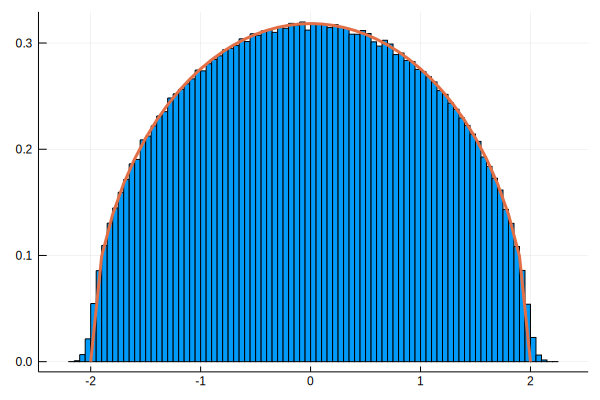

In [7]:
histogram(v, normed=true)
plot!(-2:0.1:2, semicircle, lw=3)

# Tracy–Widom distribution
Introduced by Craig Tracy and Harold Widom (1993, 1994), is the probability distribution of the normalized largest eigenvalue of a random Hermitian matrix.

In [ ]:
n = 100  # matrix size
t = 10000 # trials
vl = []  # largest eigenvalue samples

for i in 1:t
    # Sample GUE and collect their largest eigenvalues
    a=randn(ComplexF64, (n,n)) # random nxn complex matrix
    s=(a+a')/2 ; # Hermitian matrix
    append!(vl, maximum(eigvals(s))) # largest eigenvalue
end

vl=sqrt(2)*n^(1/6)*(vl.-sqrt(2*n)) # normalized largest eigenvalues

nothing

Approximation of the Tracy-Widom distribution.
See _Chiani, M. (2014). Distribution of the largest eigenvalue for real Wishart and Gaussian 
random matrices and a simple approximation for the Tracy–Widom distribution_.

In [ ]:
using SpecialFunctions

k = 79.6594870666346
θ = 0.10103655775856243
α = 9.819607173436484

pdfgamma(x, θ, k) = 1/(gamma(k)*θ^k) * x^(k - 1) .* exp(-x/θ)
tracy_widom(x) = pdfgamma(x+α, θ, k)

In [ ]:
histogram(vl, normed=true)
plot!(-5:0.01:5, tracy_widom, lw=3)

In [ ]:
n = 8  # matrix size
t = 100000 # trials
v = []  # largest eigenvalue samples

for i in 1:t
    # Sample GUE and collect all their eigenvalues
    a=randn(ComplexF64, (n,n)) # random nxn complex matrix
    s=(a+a')/2 ; # Hermitian matrix
    append!(v, eigvals(s)) # largest eigenvalue
end

This is the eigenvale distribution function for an NxN matrix (full [derivation here](https://www.youtube.com/watch?v=te6V9OvtGww)). $$\rho_N (\lambda) = \frac{1}{N \sqrt{\pi}} e^{-\lambda^2}\sum_{j=0}^{N-1}{\frac{H_j^2(\lambda \sqrt{2})}{j!}}$$ First define the first few (probabilists') [Hermite polynomials](https://en.wikipedia.org/wiki/Hermite_polynomials). Note that it is _extremely_ sensitive to proper weighting of the Hermite polynomial. Took me a while to sort that out.

In [ ]:
H0(x)=1
H1(x)=x
H2(x)=x^2 - 1
H3(x)=x^3 - 3x
H4(x)=x^4 - 6x^2 + 3
H5(x)=x^5 - 10x^3 + 15x
H6(x)=x^6 - 15x^4 + 45x^2 - 15
H7(x)=x^7 - 21x^5 + 105x^3 - 105x
Hpr = [H0,H1,H2,H3,H4,H5,H6,H7]

pdf_with_no_name(λ::Real) = (1.0/(n*√(π)))*exp(-λ^2)*sum([((Hpr[j+1](λ*√2))^2)/(factorial(j)) for j=0:n-1])

In [ ]:
histogram(v, normed=true)
plot!(-5.0:0.1:5.0, pdf_with_no_name, lw=3)

Perfect match!!

---------
PS:
Tried using [PolyChaos](https://timueh.github.io/PolyChaos.jl/stable) for the Hermite polynomial evaluation but it seems theres something seems a little off. Must be something that I'm not understanding. It would have been useful to test larger matrices.

In [ ]:
using PolyChaos
op=HermiteOrthoPoly(n)
Hpc = [(x) -> PolyChaos.evaluate(j,x,op) for j=0:n-1]

j=7
diff(x)=Hpr[j+1](x)-Hpc[j+1](x)
plot(-10:0.01:10, [Hpr[j+1], Hpc[j+1], diff], leg=true, label=["Hpr", "Hpc", "Diff"])